In [52]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

plt.style.use('intuitivebayes.mplstyle')
figsize = (24,12)

In [3]:
import pymc.sampling_jax

/home/canyon/miniconda3/envs/intuitive_bayes_gp/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/home/canyon/miniconda3/envs/intuitive_bayes_gp/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [5]:
data = pd.read_csv("data/co2_mm_mlo.csv", header=51)

# Section 30: Art different way
There's more than one way to draw a curve

## Mondrian's Art Style

<center>
  <img src="img/Mondrian.png"  />
</center>

When we said art class we weren't kidding. Here's piece of art from Mondrian and as you can tell he had a very particular mindset when making this

## Jackson Pollock

<center>
  <img src="img/Pollock.jpg" height="700" />
</center>

And here's one from Jackson pollock. Its still art, but there's a very different mentality behind how it was created. Keep that in mind as we introduce a new "art" style for our Mauna Loa challege in this section

## Revisiting our linear fit

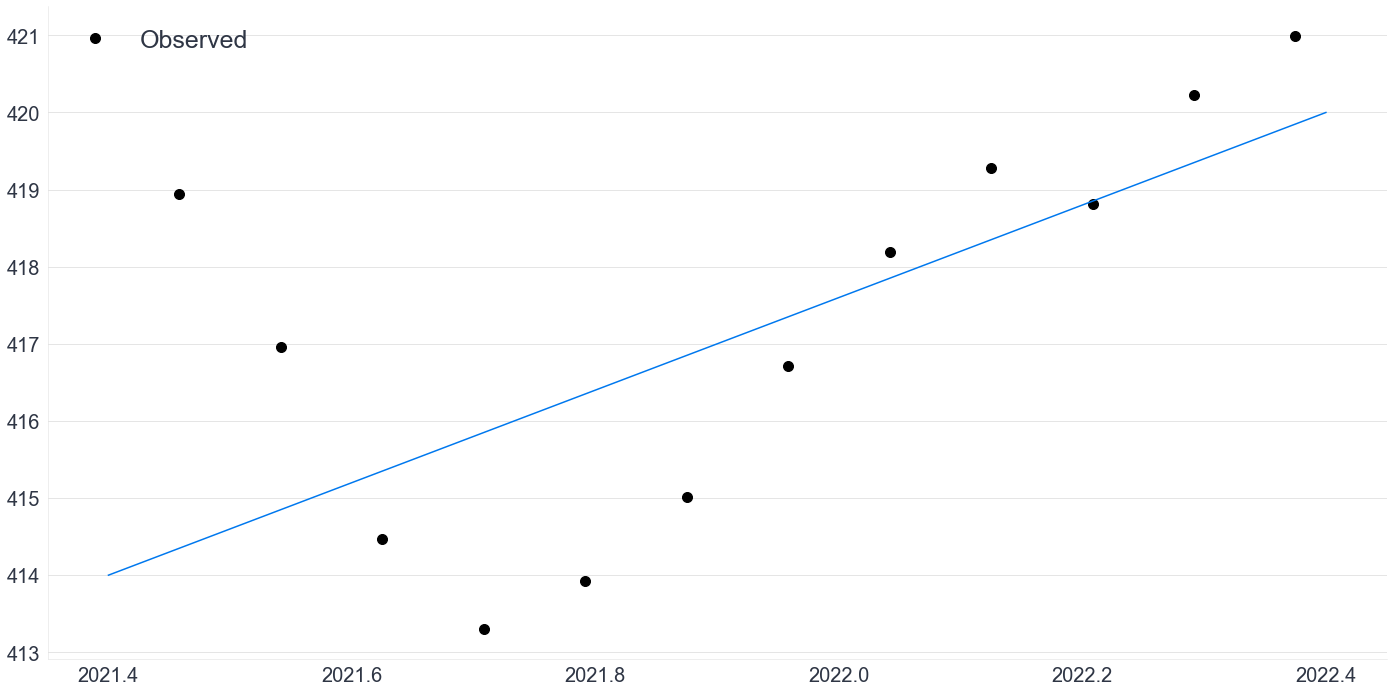

In [53]:
last_12_obs = data.sort_values("decimal date").tail(12)

# These are just guesses, need replace with the real OLD estimate
rise = 6
min_x, max_x = 2021.4, 2022.4
run = 2022.4 - min_x

m = rise/run
b = last_12_obs["average"].min()

plt.figure(figsize=figsize)

def plot_data():
    plt.plot(last_12_obs["decimal date"], last_12_obs["average"], "ko", label="Observed")
    return

def plot_best_fit_line():
    x_est = np.linspace(min_x, max_x, 100)
    y_est = m*(x_est - min_x) + 414
    plt.plot(x_est, y_est)
    return

plot_data()
plot_best_fit_line()
plt.legend();

Let's revisit our Mondrian style analysis. Remember our goal here is to estimate the C02 levels on any date, not just the observed dates. 

We decided to use a line as our first model. Here's the line we fit we fit earlier. Because we're currently fitting lines like Mondrian we're fixed to a strict functional fit. Given that this is the best we could do.

## Revisiting *how* we got to this line

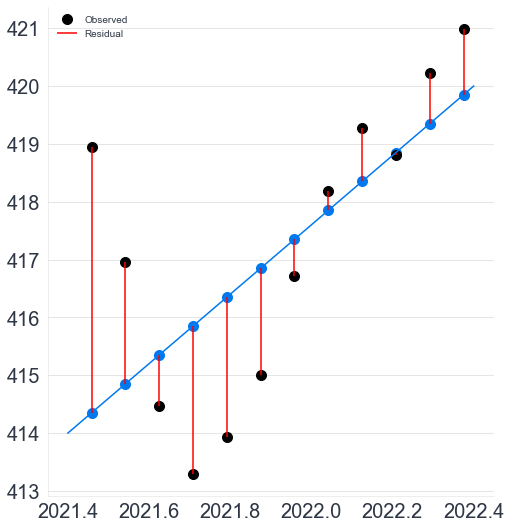

In [10]:
plt.figure(figsize=(8,9))

plot_data()
plot_best_fit_line()

# Plot Residuals
y_est_obs = m*(last_12_obs["decimal date"] - min_x) + 414

for x, y_obs, y_est in zip(last_12_obs["decimal date"].values, y_est_obs, last_12_obs["average"]):
    if x == last_12_obs["decimal date"].min():
        label = "Residual"
    else:
        label= ""
    plt.vlines(x, np.min([y_obs, y_est]), np.max([y_obs, y_est]), label=label, color="r")

plt.scatter(last_12_obs["decimal date"], y_est_obs)

plt.legend();

1. Defined a function
  * $CO2\_Level = \textbf{m}x + \textbf{b}$

2. Determined the "best" parameters given **all** the observed data
  * Minimizing sum of residuals
  * Using Bayesian estimation (which is basically the same thing)

3. Now we can make a prediction at **any** X

Here's the steps for us to get here. We...

The red lines here are the residuals that we're trying to minimize so we can get the "tighest" line

## Our Prediction for 2021.9

In [51]:
date_of_interest = 2021.911

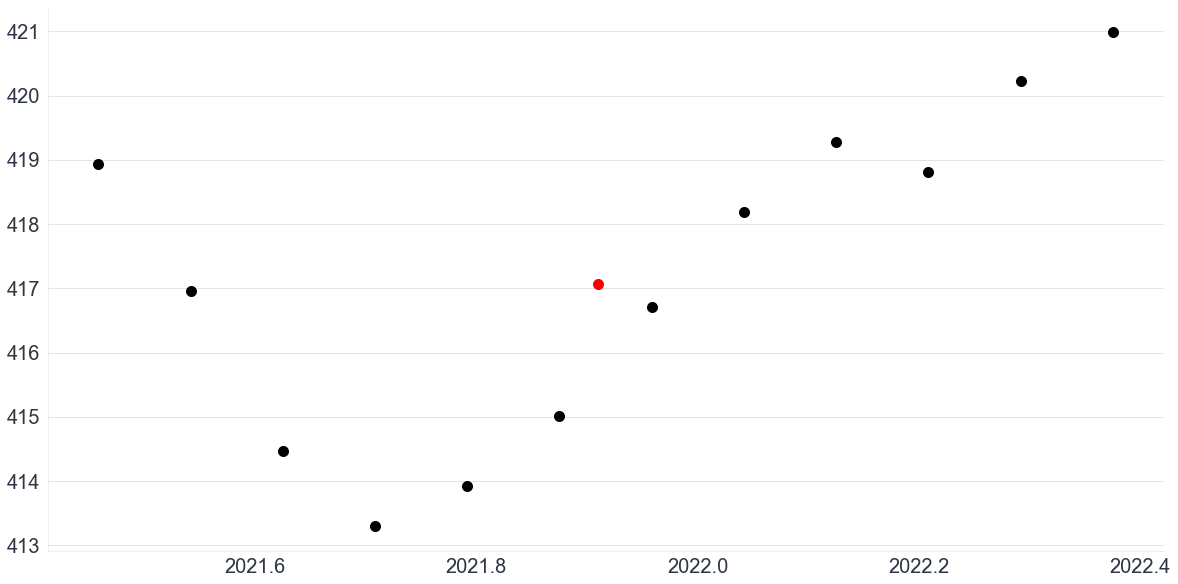

In [100]:
plt.figure(figsize=figsize)
plot_data()

est_2022 = m*(date_of_interest - min_x) + 414
plt.scatter(date_of_interest, est_2022, c="r");

Wi

## Rethinking our estimation for 2021.9

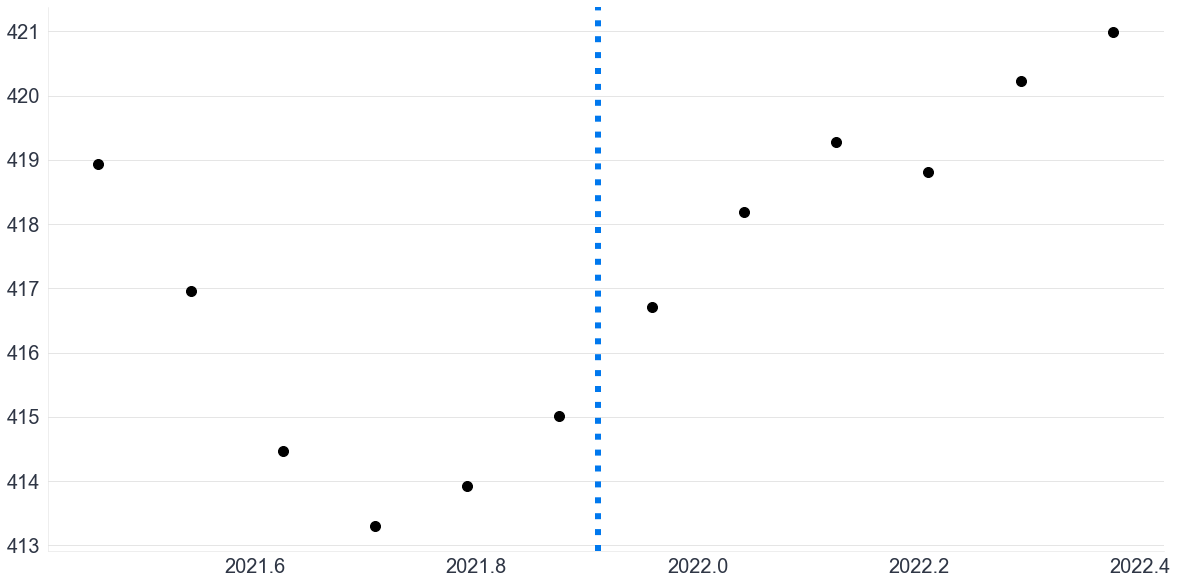

In [13]:
plt.figure(figsize=figsize)

plot_data()
plt.axvline(date_of_interest, linestyle="dotted", lw=6);

Let's just focus on one date. 2022.00. If we needed pick a point for this what where would we put it?

If we use our previous approach, since were just minimizing sum of squares, the error for this dot way far on the left, can have a greater impact for our prediction at 2022, than the points right next to 2022 our point of interest.

** Fadi highlight dot all the way to the left, and then

## Some sample points
Here's 4 proposals, there's nothing special about them, we're just picking these four to be concrete.

If we look at them, this one feels "too high", "this one" feels too low, these two seems the most plausible but this one seems right

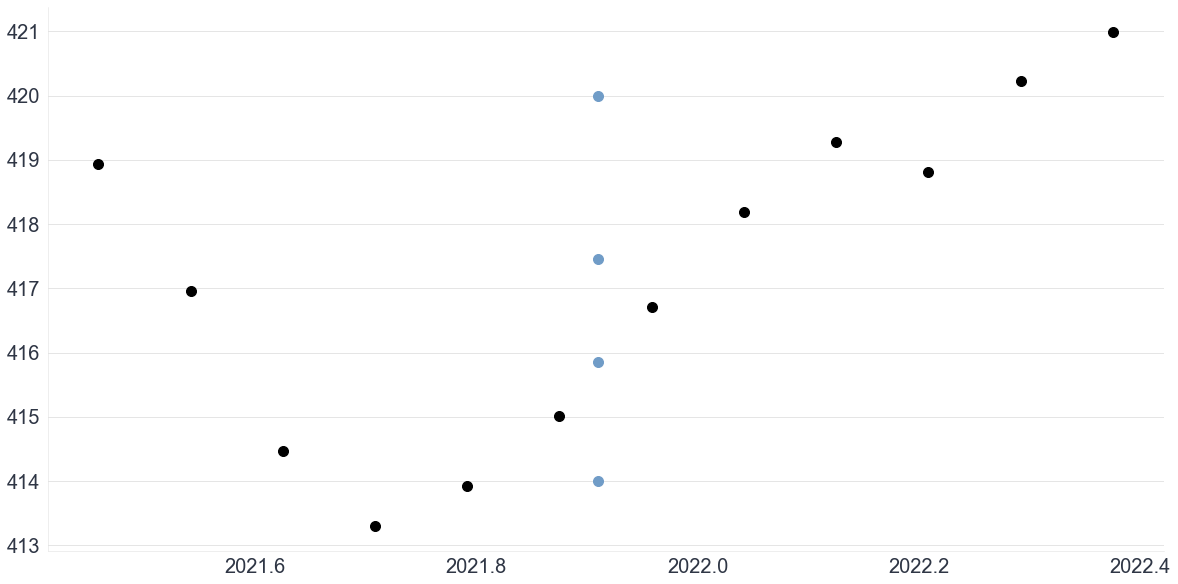

In [14]:
plt.figure(figsize=figsize)

plot_data()

y_vals = (414, 415.86, 417.45, 420)

for y_val in y_vals:
    plt.plot(date_of_interest, y_val, marker="o", c="C5")

## Using our intuition to make estimates


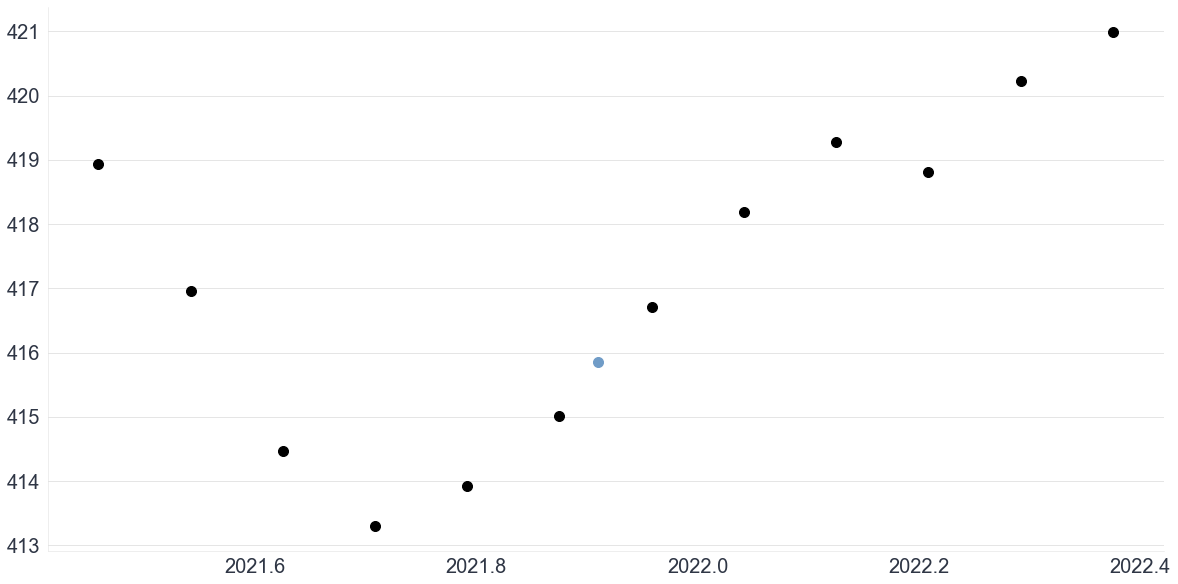

In [15]:
plt.figure(figsize=figsize)
plot_data()
plt.plot(date_of_interest, y_vals[1], marker="o", c="C5");

Our guess is you took a look at the points that were closest to 2021.9. That would be the one to the left and the right of the out date of interest. You then "eyed out" where the correct placement was. That's what we did too.

We also believe you *did not* consider these points all the way to the left and the right, or if you did they mattered a lot less than the immediately adjacent points

## Formalizing our intuition

In [18]:
(last_12_obs
     # Get the distance to all other points
    .assign(distance=np.abs(last_12_obs["decimal date"] - date_of_interest))
     
     # Sort by distance
    .sort_values("distance")
 
     # Take the top two
    .head(2)
     # Get the average
     ["average"].mean())

415.86

Because were mathematicians we can formalize this. We can take the values of the two points closest and take the average to figure out the y distance.

Lets do that again here for this point and this point. So far so good right! 

Writing down our steps.

1. Look at the two closest points
2. Take the average

##  Freeing ourselves of the functional form


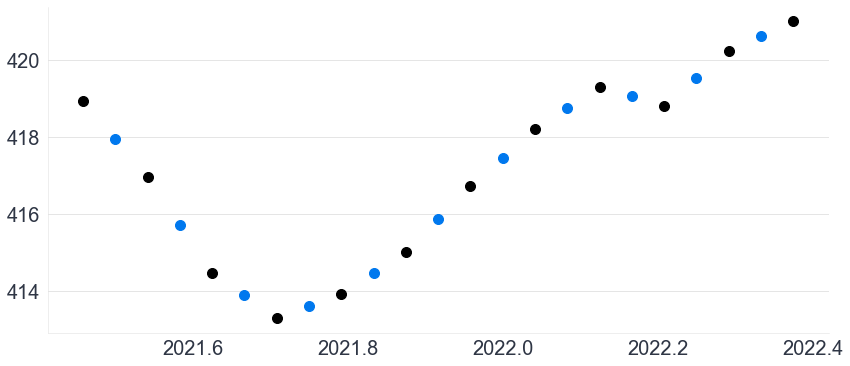

In [21]:
plt.figure(figsize=(14,6))
plot_data()


vals = last_12_obs[["decimal date", "average"]].rolling(window=2).mean()

plt.scatter(vals["decimal date"], vals["average"], marker = "o");

This is amazing now we dont need to define a functional form. This method should work equally well on any arbitrary function. Lets now fill in all the other values

## Breaking our intuition



In [38]:
date_of_interest = 2021.95

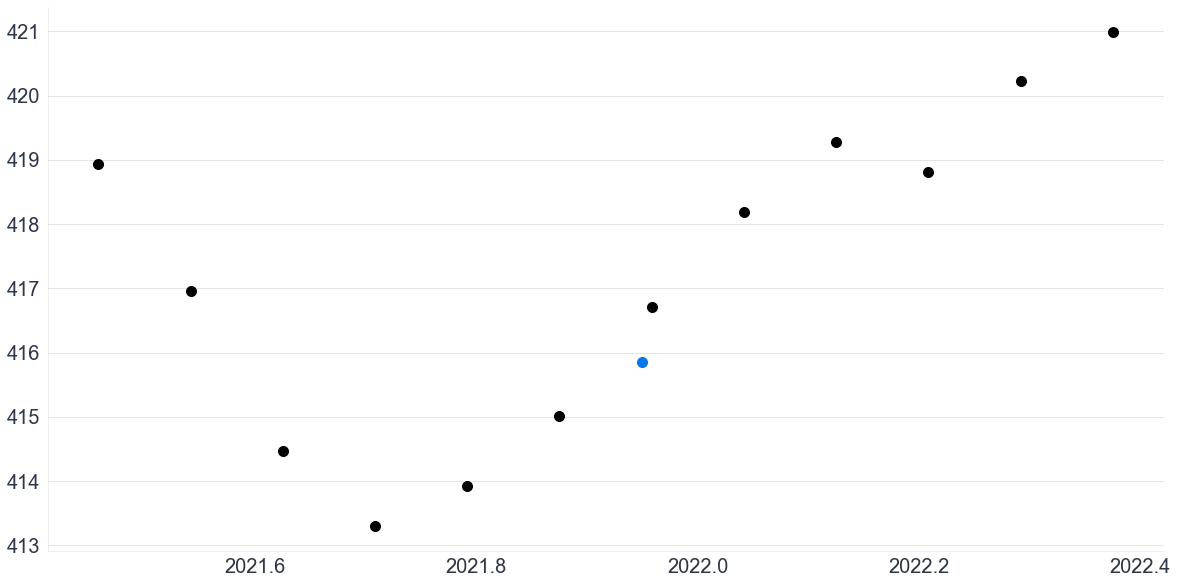

In [39]:
plt.figure(figsize=figsize)


plot_data()
y_val = (last_12_obs
    .assign(distance=np.abs(last_12_obs["decimal date"] - date_of_interest))
    .sort_values("distance")
    .head(2)
    ["average"].mean())

plt.scatter(date_of_interest, y_val);

As we move closer to the dot on the right, we'd assume that our estimated points would go up, since the dot on the right "matters more" as its closer. But because were just selecting the two closest points and averaging that doesn't work

## Moving average fit

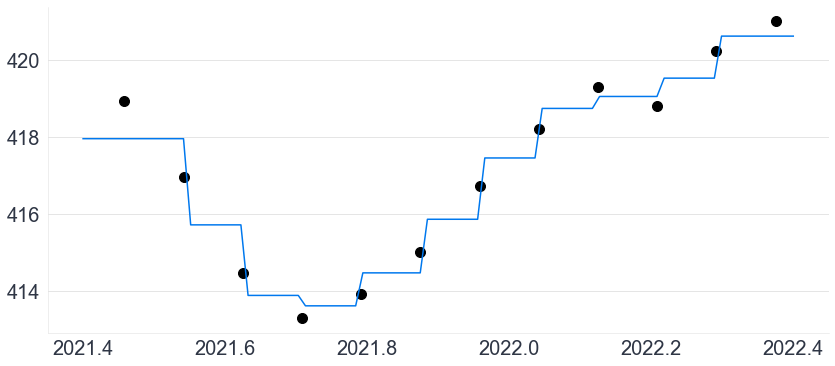

In [42]:
plt.figure(figsize=(14,6))
plot_data()
# Don't do this in real life, its very computationally wasteful
x = np.linspace(2021.4, 2022.4, 100)
y = []
for point_of_interest in x:
        
    y_val = (last_12_obs
        .assign(distance=np.abs(last_12_obs["decimal date"] - point_of_interest))
        .sort_values("distance")
        .head(2)
        ["average"].mean())

    y.append(y_val)
plt.plot(x, y);

This is what the fit looks like if we plot more points between data points. Now nothing is inherently wrong with this, moving average fits are used in time series all the time, but its not what were looking for

## What if we include more data?

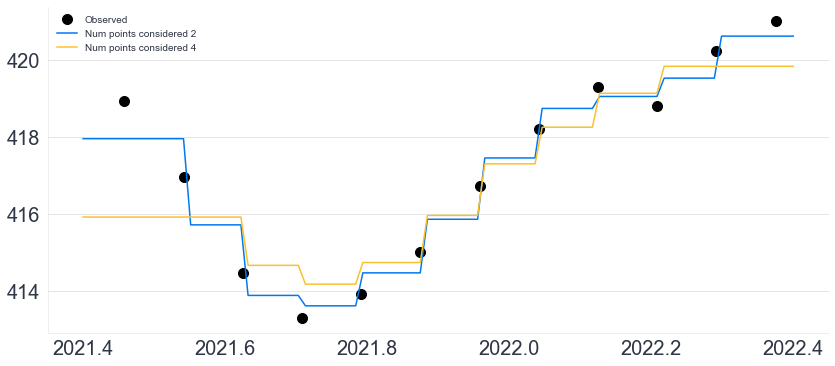

In [50]:
plt.figure(figsize=(14,6))
plot_data()
x = np.linspace(2021.4, 2022.4, 100)


for num_points_considered in (2, 4): 
    y_vals = []
    for point_of_interest in x:  
        y_val = (last_12_obs
            .assign(distance=np.abs(last_12_obs["decimal date"] - point_of_interest))
            .sort_values("distance")
            .head(num_points_considered)
            ["average"].mean())

        y_vals.append(y_val)
    plt.plot(x, y_vals, label = f"Num points considered {num_points_considered}")
plt.legend();

You might say, why only two closet data points were throwing away information. Youre right we are and its a problem. Here we picked

We made an exercise so be sure to do it to see what were talking about 

In the next section we'll show you how to overcome these of a step wise fit, and adjusting the influence of the data, all with an neat mathematical trick. For now lets go to the section recap

## Section Recap
* There are ways to find that are *not* optimizing over hand selected functional models
  * In this paradigm every data point whether close or far to a particular x value has the same weight
* Intuitively it makes sense that closer observed data should be more influential
* Windowed averaging is one method
  * Works great when the x value of interest is at the midpoint of two observations
  * Does not work so great when we start moving closer to one point or another

## Section 40: SImilarity Functions
The best of both worlds

* So we saw that averaging doesnt work and we need to weight the data somehow. Lets try this weighting function
* Wow this is so cool see how well it does so awesome
* But is this a GP? Turns out it isnt. This kernel estimator while good has a couple of issues,
 * such as lacking uncertainty
 * Something Else
 * Something else

* A full GP solves those issues
* What a full GP would look like is this but as you can see there's a lot more going on. Thatll be for the next lesson

# Art class lesson recap
* Functional forms are great people use them all the time
  * but you gotta figure out the function
  * There might not be a function that fits your data
* Its much more intuitive to use the closest data points to draw a line.
* Moving average is one way to do that but it has challenges
* Kernels let us weight data point which is great but again is lacking in some ways
* GPs solve all these issues